In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from pydub import AudioSegment
from scipy.interpolate import *
import datetime

def mp3_to_samples(filename,rate=None):
    """
    Returns
    samples, sample_rate: samples of the mp3 and the sample rate
    """
    return librosa.load(filename,sr=rate)

def samples_to_freq(sample_arr):
    """
    Returns
    mag_arr: 2d array of magnitudes in frequency-time
    """
    freq_arr = librosa.stft(sample_arr)
    mag_arr = np.abs(freq_arr) # |z| = sqrt(k**2 + j**2) reduce complex component
    return mag_arr,freq_arr

def graph_spectro(freq_amp,rate,figsize=None,save_n=None):
    """
    Display a spectrogram of the provided freq_amp data
    """
    plt.subplots(figsize=figsize)
    librosa.display.specshow(librosa.amplitude_to_db(freq_amp, ref=np.max), sr=rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    if save_n:
        plt.savefig(save_n)
    plt.show()

def lazy_graph(filename,figsize=None,save_n=None):
    """
    All in one helper to import file, FFT, and graph the result
    """
    samp,rate = mp3_to_samples(filename)
    graph_spectro(samples_to_freq(samp),rate,figsize=figsize,save_n=save_n)

def get_interp_fun(samples, degree=3):
    """
    Returns
    spl() - interpolating function for samples
    """
    x = np.arange(0,2*len(samples),2)
    return InterpolatedUnivariateSpline(x,samples)

def remove_half_samples(samples):
    """
    Returns
    samples at only even indices (for lossy interpolating odd samples)
    """
    return samples[::2]

def interp_odd_samples(samples, spl, length):
    """
    Efficiently interlace samples with interpolated values using spl() to reconstruct an array of length
    Returns
    inter_samples - interlaced sample and interpolated values
    """
    even_idx = np.arange(0, length, 2)
    odd_idx = np.arange(1, length, 2)
    
    odd_elms = spl(odd_idx)
    
    inter_samples = np.empty(length)
    inter_samples[even_idx] = samples
    inter_samples[odd_idx] = odd_elms
    return inter_samples

def freq_to_samples(freq_arr):
    """
    Take frequency domain and istft back to amplidute samples
    """
    return librosa.istft(freq_arr)

def save_samples_to_wav(samples,sr,filename):
    """
    Take samples and save to .wav audio file.
    Not saving to mp3 because mp3 is lossy. No point.
    """
    sf.write(filename,samples,sr)

def sample_plot(samples, sr, title=None, interval=None ,figsize=None,save_n=None):
    plt.subplots(figsize=figsize)
    if interval:
        x = np.arange(*interval)
    else:
        x = np.arange(len(samples))
    print('start vectorize')
    x_labels = np.vectorize(lambda i: str(datetime.timedelta(seconds=int(i//sr)))[2:])(x[::len(x)//8])
    # x = list(map(lambda i: str(datetime.timedelta(seconds=int(i)))[2:], x))
    # x = [str(datetime.timedelta(seconds=int(i)))[2:] for i in x] # convert from sec to min:sec
    print('fin vec')
    plt.plot(x,samples)
    plt.xticks(x, x_labels)
    if title:
        plt.title(title)
    if save_n:
        plt.savefig(save_n)
    plt.show()

def full_pipeline(filename, save_dir=None, testname=None, chunks=1,chunk_num=0):
    if not testname:
        testname = filename
    smps,sr = mp3_to_samples(filename)
    n = len(smps)
    chunk_interval = None
    # take the chunk_num-th chunk of smps divided into chunks
    if chunks != 1 and chunks != 0: # no div by 0
        if chunks < 0: # no negs, just flip sign
            chunks *= -1
        chunksize = n//chunks
        smps = smps[chunk_num*chunksize:(chunks+1)*chunksize]
        chunk_interval = (chunk_num*chunksize,(chunks+1)*chunksize)
    half_smps = remove_half_samples(smps)
    spline = get_interp_fun(half_smps)
    recon_smps = interp_odd_samples(half_smps,spline,n)

    fmag_recon,freq_recon = samples_to_freq(recon_smps)
    fmag_orig,freq_orig = samples_to_freq(smps)
    
    sample_plot(smps, sr, title=f'{testname}: Original Samples', interval=chunk_interval)

In [2]:
tribe_samps,sr = mp3_to_samples("samples/Bas - Tribe with J.Cole.mp3")
# anote,_ = mp3_to_samples("samples/440Hz_44100Hz_16bit_05sec.mp3")
tribe_samps = tribe_samps[:len(tribe_samps)//32]

In [3]:
hlv_trb = remove_half_samples(tribe_samps)
spl = get_interp_fun(hlv_trb) # cubic interpolation of reduced sample set
reconstructed = interp_odd_samples(hlv_trb,spl,len(tribe_samps))

In [ ]:
sample_plot(tribe_samps, sr)
sample_plot(reconstructed, sr)
sample_plot(hlv_trb, sr)

start vectorize
fin vec


In [7]:
freq_recon,freq_recon_ = samples_to_freq(reconstructed)
freq_orig,freq_orig_ = samples_to_freq(tribe_samps)

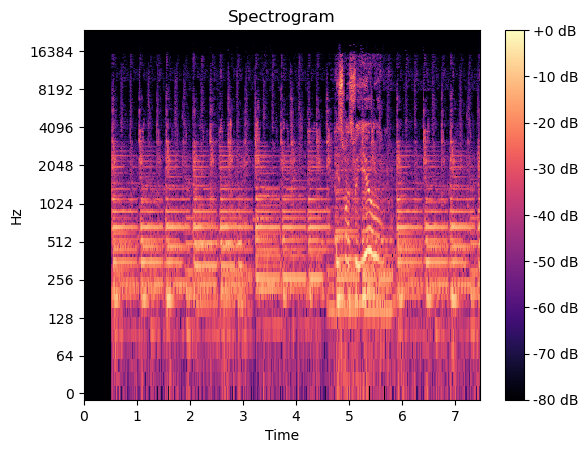

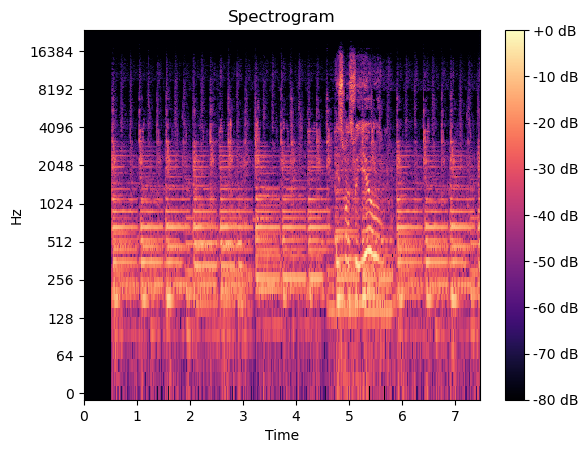

In [8]:
graph_spectro(freq_orig,sr)
graph_spectro(freq_recon,sr)

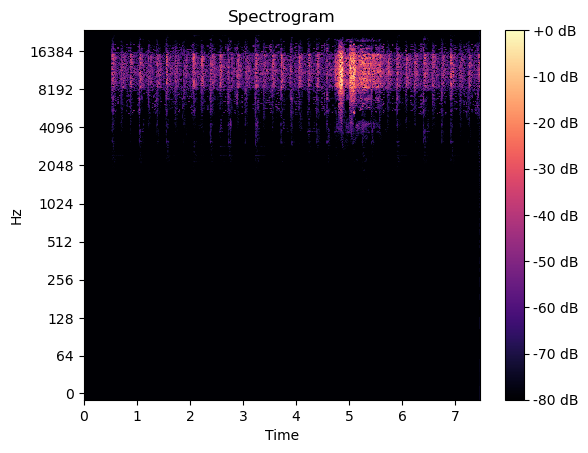

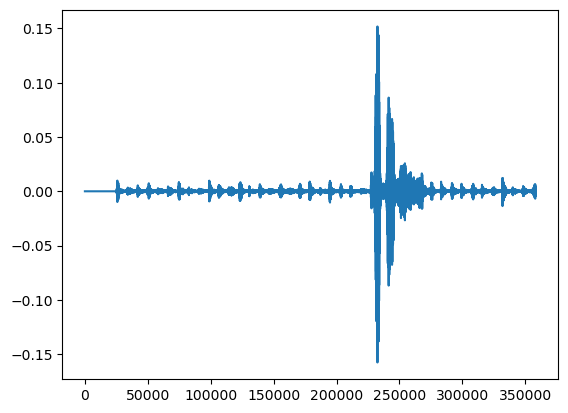

In [9]:
diff_ = freq_orig_-freq_recon_
diff = freq_orig-freq_recon
graph_spectro(diff,sr)
diff_samples = freq_to_samples(diff_)
plt.plot(np.arange(len(diff_samples)),diff_samples)
plt.show();

In [10]:
save_samples_to_wav(diff_samples,sr,"tribe_first32nd_diff.wav")

/tmp/ipykernel_23217/1321435208.py:30: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(freq_amp, ref=np.max), sr=rate, x_axis='time', y_axis='log')


ValueError: too many values to unpack (expected 2)

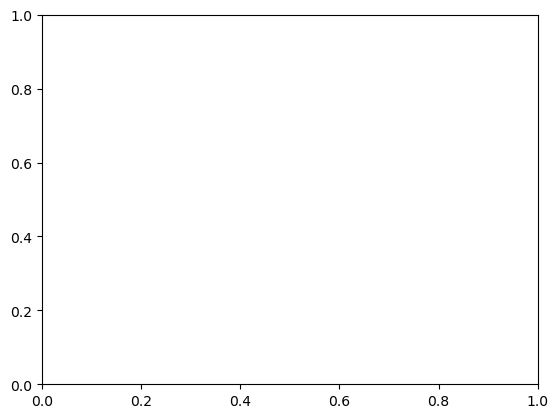

In [11]:
lazy_graph('samples/sample-4.mp3')
# lazy_graph('samples/sample-3.mp3')
# lazy_graph("samples/Bas - Tribe with J.Cole.mp3",figsize=(24,4),save_n='tribe_4x24.png')

In [ ]:

mp3_to_samples("samples/sample-0.mp3")

In [ ]:
rng = np.random.default_rng()

x = np.linspace(0, 50, 50)
print(hlv_trb[50000:50050])
y = hlv_trb[50000:50050]

spl = InterpolatedUnivariateSpline(x, y)

plt.plot(x, y, 'ro', ms=5)

xs = np.linspace(0, 100, 100) #np.linspace(-3, 3, 1000

plt.plot(xs, spl(xs), 'g', lw=3, alpha=0.7)

plt.show()

In [ ]:
np.linspace(0, 100, 100).astype(int)

print(np.arange(0, 100).astype(int))
np.arange(0, 200, 2).astype(int)

In [33]:
import datetime
x = np.arange(40)
[str(datetime.timedelta(seconds=int(o)))[2:] for o in i]
list(map(lambda i: str(datetime.timedelta(seconds=int(i)))[2:], x))

['00:00',
 '00:01',
 '00:02',
 '00:03',
 '00:04',
 '00:05',
 '00:06',
 '00:07',
 '00:08',
 '00:09',
 '00:10',
 '00:11',
 '00:12',
 '00:13',
 '00:14',
 '00:15',
 '00:16',
 '00:17',
 '00:18',
 '00:19',
 '00:20',
 '00:21',
 '00:22',
 '00:23',
 '00:24',
 '00:25',
 '00:26',
 '00:27',
 '00:28',
 '00:29',
 '00:30',
 '00:31',
 '00:32',
 '00:33',
 '00:34',
 '00:35',
 '00:36',
 '00:37',
 '00:38',
 '00:39']